In [1]:
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt

# Model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pylab
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.api import ExponentialSmoothing

In [2]:
df = pd.read_csv("retail_store_inventory.csv")

In [3]:
df

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,2024-01-01,S005,P0016,Furniture,East,96,8,127,18.46,73.73,20,Snowy,0,72.45,Winter
73096,2024-01-01,S005,P0017,Toys,North,313,51,101,48.43,82.57,10,Cloudy,0,83.78,Autumn
73097,2024-01-01,S005,P0018,Clothing,West,278,36,151,39.65,11.11,10,Rainy,0,10.91,Winter
73098,2024-01-01,S005,P0019,Toys,East,374,264,21,270.52,53.14,20,Rainy,0,55.80,Spring


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

In [5]:
df["Date"] = pd.to_datetime(df["Date"], errors='coerce') #handle datatype 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                73100 non-null  datetime64[ns]
 1   Store ID            73100 non-null  object        
 2   Product ID          73100 non-null  object        
 3   Category            73100 non-null  object        
 4   Region              73100 non-null  object        
 5   Inventory Level     73100 non-null  int64         
 6   Units Sold          73100 non-null  int64         
 7   Units Ordered       73100 non-null  int64         
 8   Demand Forecast     73100 non-null  float64       
 9   Price               73100 non-null  float64       
 10  Discount            73100 non-null  int64         
 11  Weather Condition   73100 non-null  object        
 12  Holiday/Promotion   73100 non-null  int64         
 13  Competitor Pricing  73100 non-null  float64   

In [7]:
store1=df[df["Store ID"]=="S001"]
store2=df[df["Store ID"]=="S002"]
store3=df[df["Store ID"]=="S003"]
store4=df[df["Store ID"]=="S004"]
store5=df[df["Store ID"]=="S005"]

In [8]:
data=store1 # 1. store 

data.count()

Date                  14620
Store ID              14620
Product ID            14620
Category              14620
Region                14620
Inventory Level       14620
Units Sold            14620
Units Ordered         14620
Demand Forecast       14620
Price                 14620
Discount              14620
Weather Condition     14620
Holiday/Promotion     14620
Competitor Pricing    14620
Seasonality           14620
dtype: int64

In [9]:
sp1 = data.groupby(['Date','Product ID']).sum()
sp1

/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_11047/3981719073.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sp1 = data.groupby(['Date','Product ID']).sum()


Inventory Level  Units Sold  Units Ordered  \
Date       Product ID                                               
2022-01-01 P0001                   231         127             55   
           P0002                   204         150             66   
           P0003                   102          65             51   
           P0004                   469          61            164   
           P0005                   166          14            135   
...                                ...         ...            ...   
2024-01-01 P0016                    74          13            189   
           P0017                   282         186             61   
           P0018                   191          29             95   
           P0019                   149         145             85   
           P0020                   242          52            198   

                       Demand Forecast  Price  Discount  Holiday/Promotion  \
Date       Product ID                                                        
2022-01-01 P0001                135.47  33.50        20                  0   
           P0002                144.04  63.01        20                  0   
           P0003                 74.02  27.99        10                  1   
           P0004                 62.18  32.72        10                  1   
           P0005                  9.26  73.64         0                  0   
...                                ...    ...       ...                ...   
2024-01-01 P0016                 27.53  40.61        10                  1   
           P0017                201.40  20.68         0                  0   
           P0018                 25.01  24.10         5                  1   
           P0019                154.83  81.71        20                  0   
           P0020                 50.82  11.00         0                  0   

                       Competitor Pricing  
Date       Product ID                      
2022-01-01 P0001                    29.69  
           P0002                    66.16  
           P0003                    31.32  
           P0004                    34.74  
           P0005                    68.95  
...                                   ...  
2024-01-01 P0016                    35.76  
           P0017                    17.23  
           P0018                    23.13  
           P0019                    80.86  
           P0020                     7.46  

[14620 rows x 8 columns]

In [10]:
sp1_filtered = sp1.loc[sp1.index.get_level_values('Product ID') == 'P0001']
sp1_filtered

,,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing
Date,Product ID,,,,,,,,
2022-01-01,P0001,231,127,55,135.47,33.50,20,0,29.69
2022-01-02,P0001,116,81,104,92.94,27.95,10,0,30.89
2022-01-03,P0001,154,5,189,5.36,62.70,20,0,58.22
2022-01-04,P0001,85,58,193,52.87,77.88,15,1,75.99
2022-01-05,P0001,238,147,37,150.27,28.46,20,1,29.40
...,...,...,...,...,...,...,...,...,...
2023-12-28,P0001,104,67,64,78.15,77.61,0,1,78.00
2023-12-29,P0001,224,168,35,184.45,14.01,15,1,18.51
2023-12-30,P0001,208,30,167,20.66,57.00,10,0,54.92


In [11]:
# Reset only 'Product ID' while keeping 'Date' in the index.
sp1_filtered_reset = sp1_filtered.reset_index(level='Product ID', drop=True)

sp1_filtered_reset

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing
Date,,,,,,,,
2022-01-01,231,127,55,135.47,33.50,20,0,29.69
2022-01-02,116,81,104,92.94,27.95,10,0,30.89
2022-01-03,154,5,189,5.36,62.70,20,0,58.22
2022-01-04,85,58,193,52.87,77.88,15,1,75.99
2022-01-05,238,147,37,150.27,28.46,20,1,29.40
...,...,...,...,...,...,...,...,...
2023-12-28,104,67,64,78.15,77.61,0,1,78.00
2023-12-29,224,168,35,184.45,14.01,15,1,18.51
2023-12-30,208,30,167,20.66,57.00,10,0,54.92


In [12]:
unit = sp1_filtered_reset[['Units Sold']]
unit['Units Sold'] = unit['Units Sold'].apply(lambda x: x if x > 0 else 1)

/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_11047/3359124885.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unit['Units Sold'] = unit['Units Sold'].apply(lambda x: x if x > 0 else 1)


Text(0, 0.5, 'Units Sold')

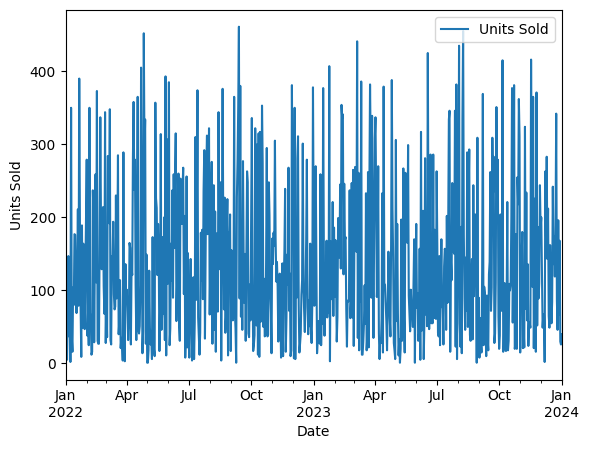

In [13]:
# Plot data
unit.plot()
plt.xlabel('Date')
plt.ylabel('Units Sold')

In [14]:
frequency = pd.infer_freq(unit.index)
print(frequency)

D


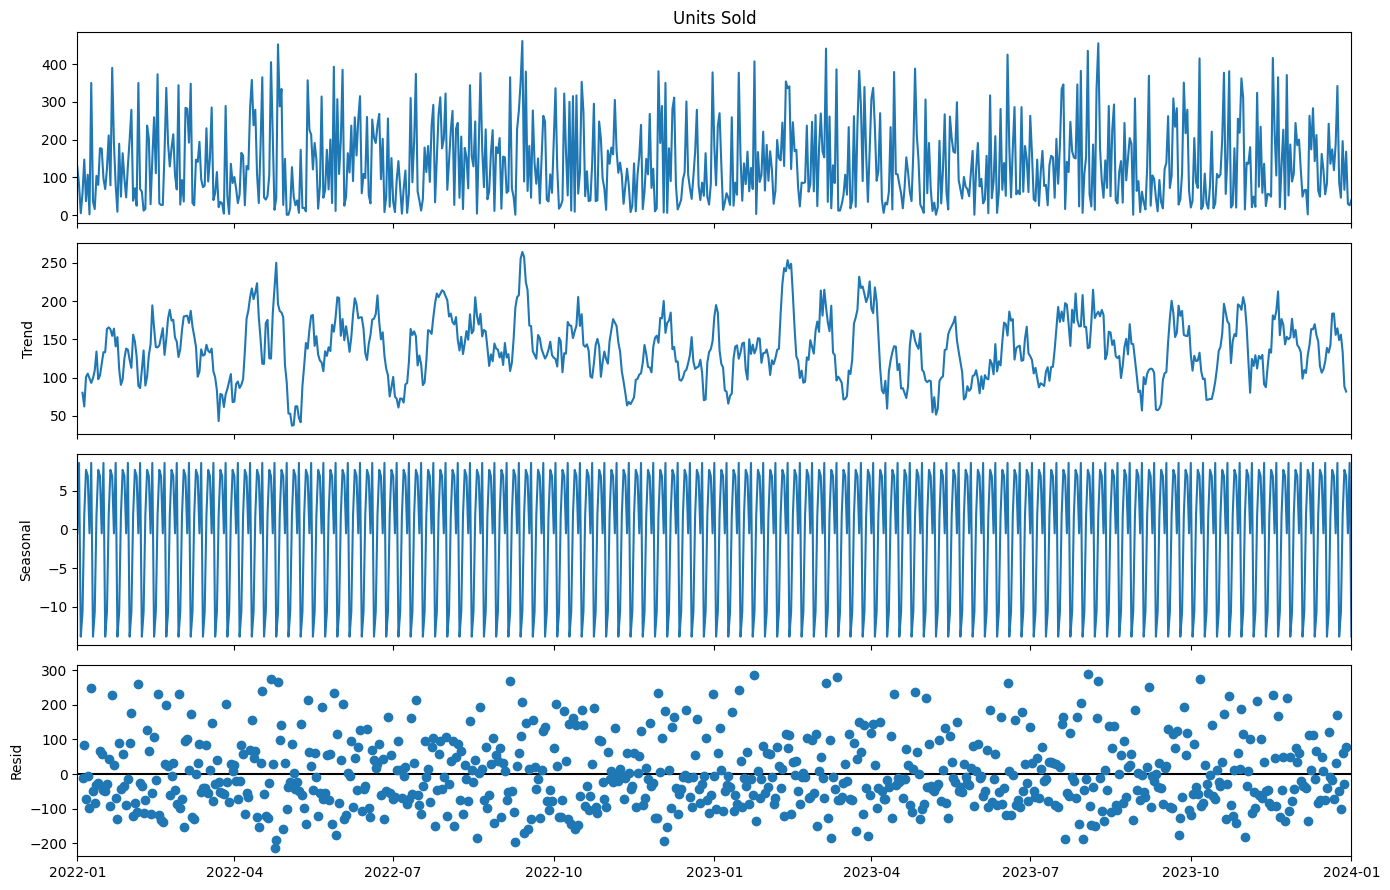

In [15]:
pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(unit['Units Sold'], model='addictive')
ax=res.plot()
plt.show()

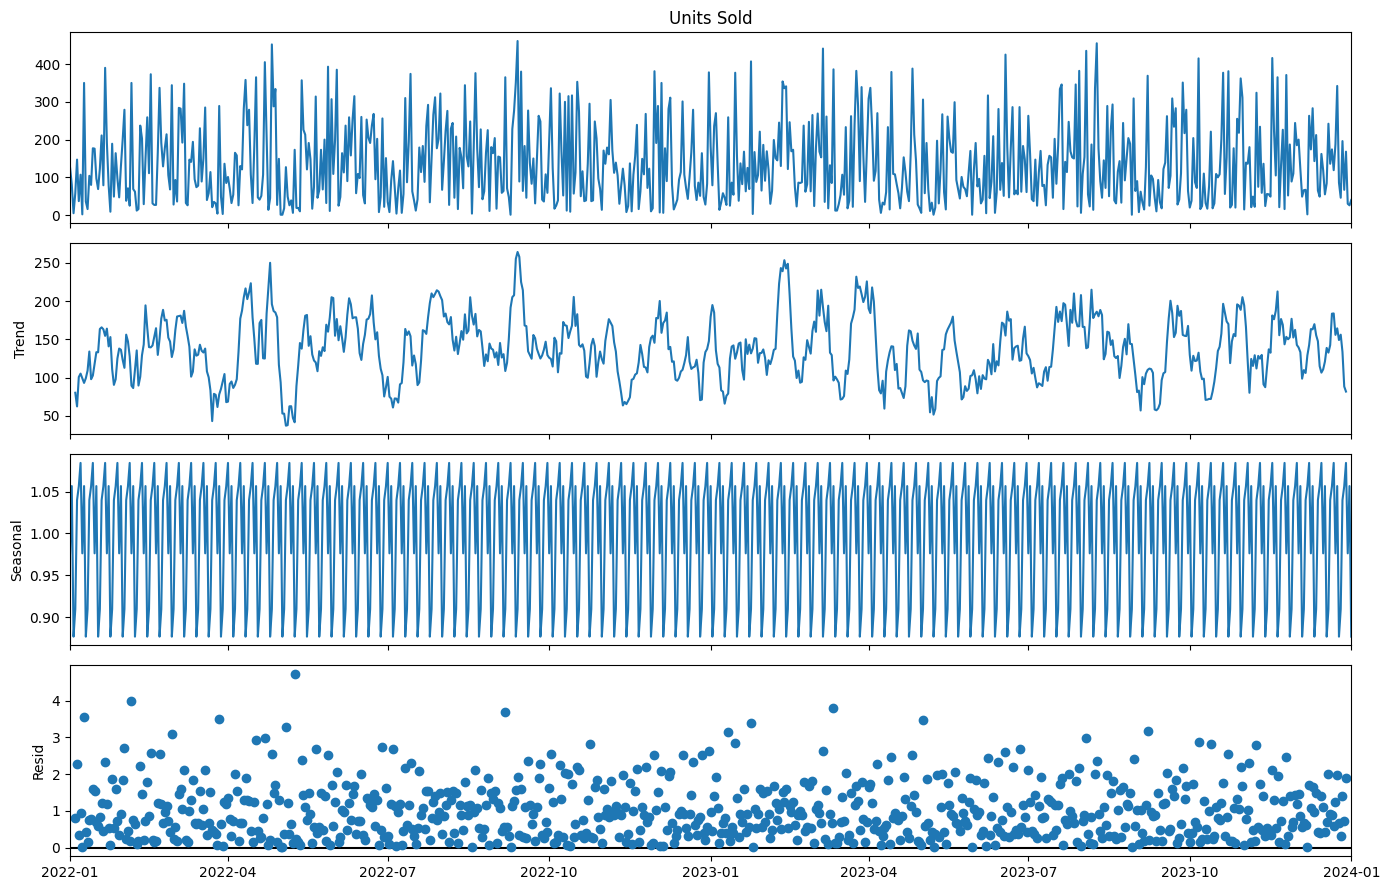

In [16]:
pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(unit['Units Sold'], model='multiplicative')
ax=res.plot()
plt.show()

In [17]:
len(unit)

731

In [18]:
train = unit[:512]
test = unit[512:]

print('Train size : ', train.shape)
print('Test size : ', test.shape)

Train size :  (512, 1)
Test size :  (219, 1)


In [20]:
# Function to check stationarity

def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [21]:
check_stationarity(train['Units Sold'])

ADF Statistic: -22.236430
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570
Stationary


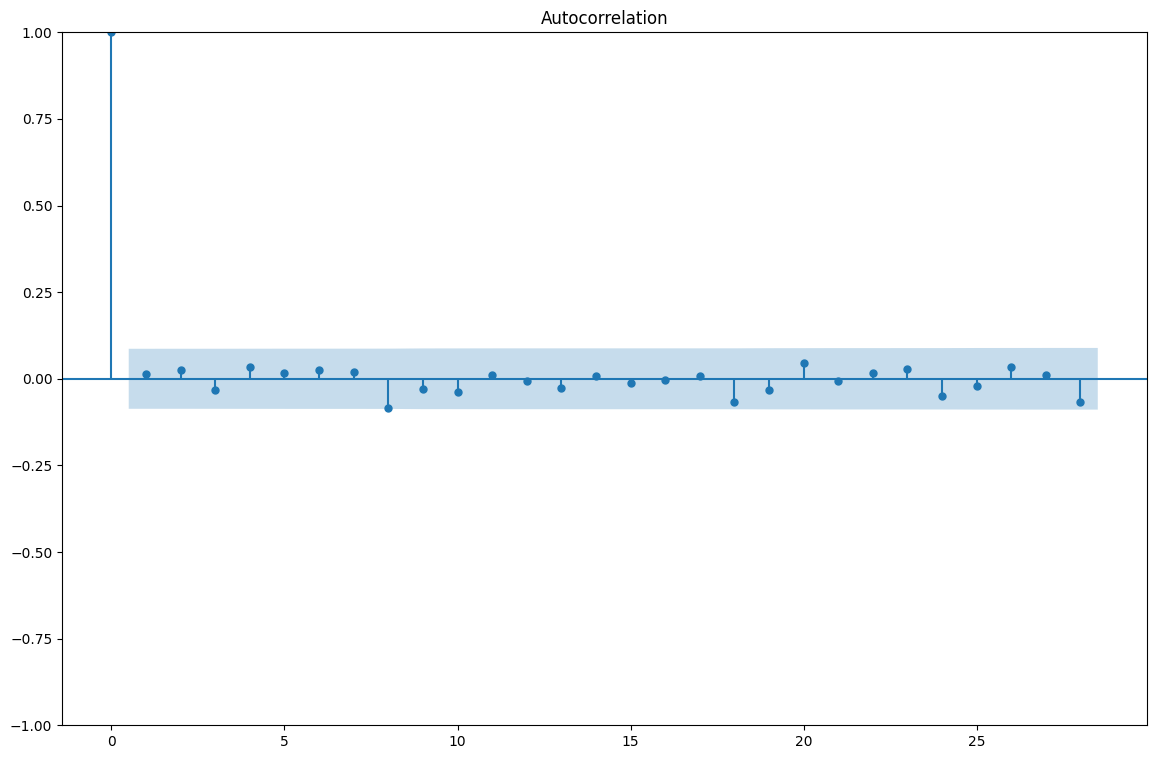

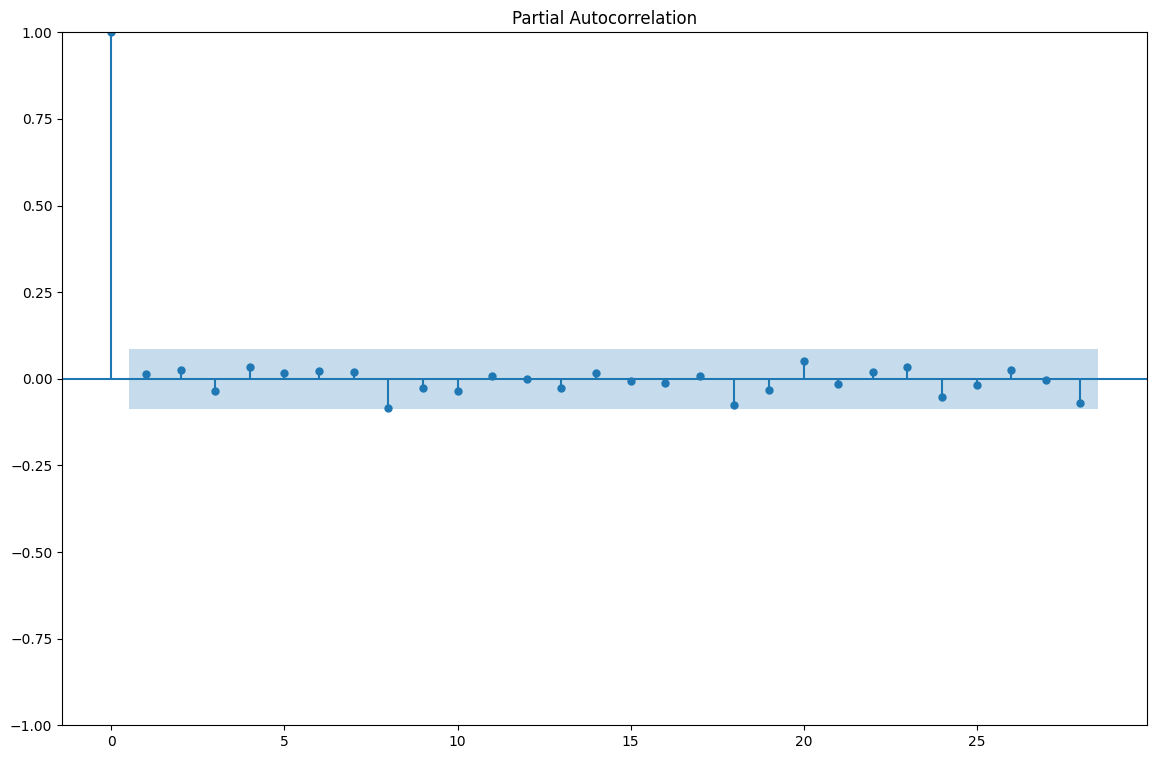

In [22]:
# Plot ACF & PACF after performing first-order differencing

plot_acf(train['Units Sold'])
plot_pacf(train['Units Sold'])
plt.show()

In [24]:
# Train ARIMA

model_arima1 = ARIMA(train['Units Sold'], order=(8, 0, 8))
result_model_arima1 = model_arima1.fit()

print('The AIC is ', result_model_arima1.aic)

/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA par

The AIC is  6268.12490940926


/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [26]:
# Train ARIMA

model_sar1 = SARIMAX(train['Units Sold'], order=(8, 0, 8), seasonal_order=(8, 0, 8, 12))
result_model_sar1 = model_sar1.fit()

print('The AIC is ', result_model_sar1.aic)

/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.10956D+00    |proj g|=  1.08644D-01


 This problem is unconstrained.



At iterate    5    f=  6.09396D+00    |proj g|=  2.96686D-02

At iterate   10    f=  6.08695D+00    |proj g|=  1.51620D-02

At iterate   15    f=  6.08534D+00    |proj g|=  1.30646D-02

At iterate   20    f=  6.08322D+00    |proj g|=  3.84678D-02

At iterate   25    f=  6.08174D+00    |proj g|=  2.68269D-02

At iterate   30    f=  6.07920D+00    |proj g|=  1.53398D-02

At iterate   35    f=  6.07693D+00    |proj g|=  5.40715D-02

At iterate   40    f=  6.07628D+00    |proj g|=  2.01563D-02

At iterate   45    f=  6.07477D+00    |proj g|=  2.21276D-02


/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.07452D+00    |proj g|=  1.28745D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     55      1     0     0   1.287D-02   6.075D+00
  F =   6.0745205686630594     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
The AIC is  6286.309062310973


In [27]:
pred_test = result_model_arima1.predict(start=test.index[0], end=test.index[-1])
mae = mean_absolute_error(test, pred_test)
mape = mean_absolute_percentage_error(test, pred_test)
print('MAE ARIMA 1 : ', mae)
print('MAPE ARIMA 1 : ', mape)

MAE ARIMA 1 :  88.84835336626077
MAPE ARIMA 1 :  3.3138729773801385


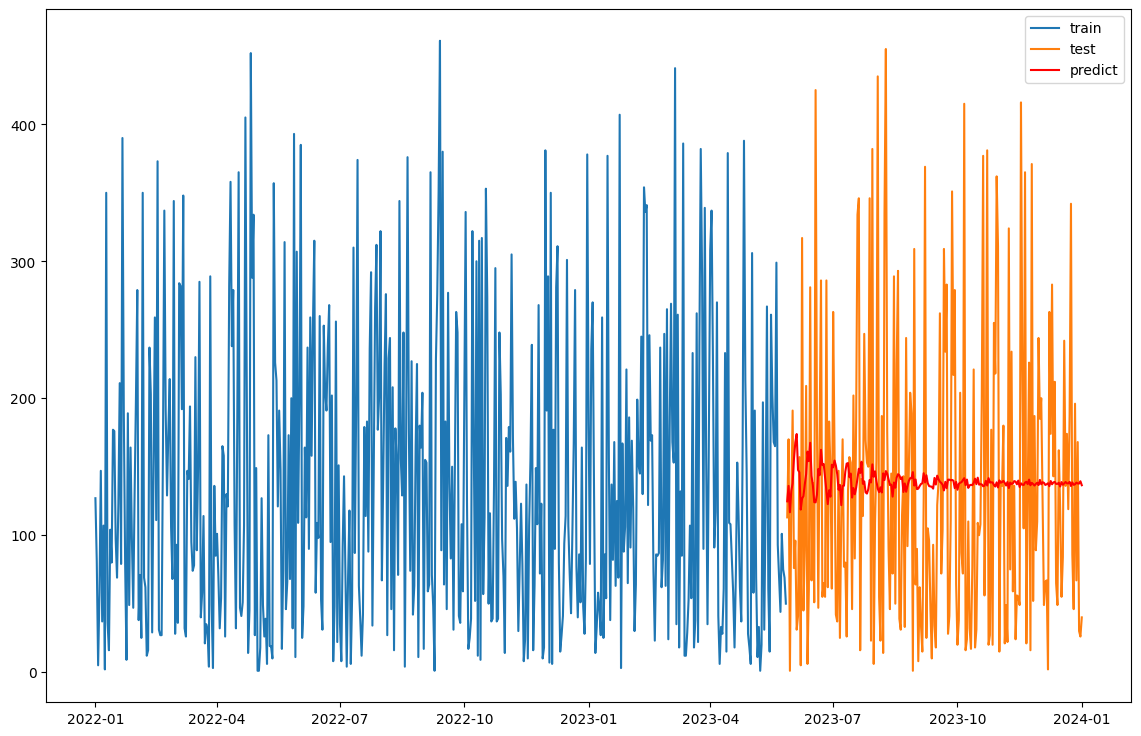

In [28]:
plt.plot(train, label = 'train')
plt.plot(test, label = 'test')
plt.plot(pred_test, color = 'red', label = 'predict')
plt.legend()
plt.show()

In [29]:
pred_test = result_model_sar1.predict(start=test.index[0], end=test.index[-1])
mae = mean_absolute_error(test, pred_test)
mape = mean_absolute_percentage_error(test, pred_test)
print('MAE SARIMAX 1 : ', mae)
print('MAPE SARIMAX 1 : ', mape)

MAE SARIMAX 1 :  89.09733186386627
MAPE SARIMAX 1 :  3.28094840986301


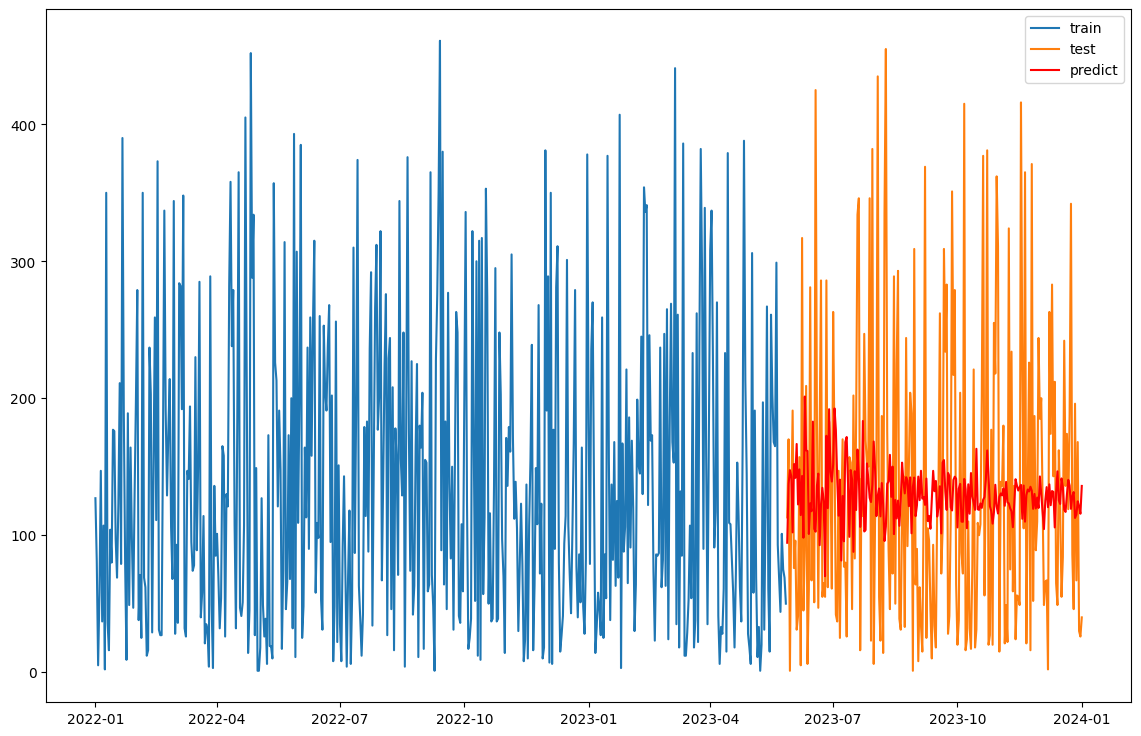

In [30]:
plt.plot(train, label = 'train')
plt.plot(test, label = 'test')
plt.plot(pred_test, color = 'red', label = 'predict')
plt.legend()
plt.show()

In [ ]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['value']) ,seasonal_periods=12 ,trend='multiplicative', seasonal='multiplicative',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot( train['value'], label='Train')
plt.plot(test['value'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()